In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from configs import umap_configs, model_configs, exp_configs
from utils import get_squashed_mask, get_step_signal, cosine_sim, linear_cka_sim

plt.style.use('tableau-colorblind10')

/Users/kwangheechoi/workspace/dysarthria-mtl/envs/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


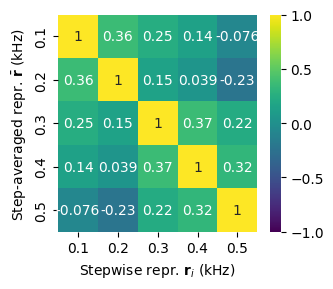

In [3]:
f0s = np.array(exp_configs["f0_dist"]["freq"])
results = pickle.load(open(f"./pkls/base_local_f0_dist.pkl", "rb"))
feats = results["feats"]
raw_feats = results["raw_feats"]


dists = np.zeros((len(feats), len(feats)))
for i in range(len(feats)):
    for j in range(len(feats)):
        dists[i][j] = cosine_sim(feats[i][None, :], raw_feats[j]).mean()

labels = [f"{f0/1000:.1f}" for f0 in f0s]
plt.figure(figsize=(3.5, 3))
ax = sns.heatmap(dists, annot=True, cmap="viridis", vmin=-1, vmax=1, xticklabels=labels, yticklabels=labels)
ax.set(xlabel=r"Stepwise repr. $\mathbf{r}_i$ (kHz)", ylabel=r"Step-averaged repr. $\bar{\mathbf{r}}$ (kHz)")
plt.tight_layout()
plt.savefig("plots/fig-temporal-step-cos.pdf", bbox_inches="tight")

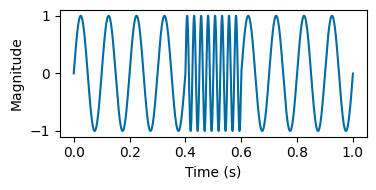

In [4]:
sig, mask = get_step_signal(base_freq=10, sig_freq=40, sig_dur_ratio=0.2)
plt.figure(figsize=(4, 2))
plt.plot(np.linspace(0, 1, 16000), sig.numpy())
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.savefig("plots/fig-temporal-signal-example.pdf", bbox_inches="tight")

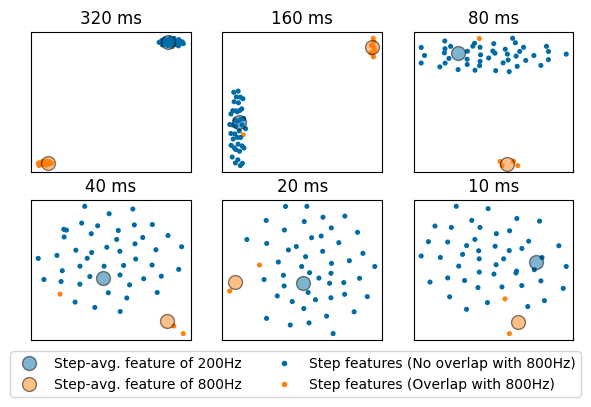

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(7, 4))
axes = axes.flatten()

for i, dur in enumerate([0.32, 0.16, 0.08, 0.04, 0.02, 0.01]):
    results = pickle.load(open(f"./pkls/base_local_window{dur:.2f}.pkl", "rb"))
    embs = results["embs"]
    mask = results["mask"]
    
    m1 = axes[i].plot(embs[-2, 0], embs[-2, 1], "o", c="C0", markersize=10.0, alpha=0.5, markeredgecolor="black")
    m2 = axes[i].plot(embs[-1, 0], embs[-1, 1], "o", c="C1", markersize=10.0, alpha=0.5, markeredgecolor="black")
    m3 = axes[i].scatter(
        embs[:-2, 0], embs[:-2, 1],
        c=[("C1" if m > 0.0 else "C0") for m in get_squashed_mask(mask)],
        alpha=1.0, s=7.0
    )
    axes[i].set_title(f"{dur * 1000:.0f} ms")
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

lgd = fig.legend(
    [m1[0], m2[0], mpl.lines.Line2D([0], [0], color="C0", linewidth=0.0, marker='.'), mpl.lines.Line2D([0], [0], color="C1", linewidth=0.0, marker=".")],
    ["Step-avg. feature of 200Hz", "Step-avg. feature of 800Hz", "Step features (No overlap with 800Hz)", "Step features (Overlap with 800Hz)"],
    # bbox_to_anchor=(0.98, 0.02), ncol=2,
    loc="lower center", ncol=2, bbox_to_anchor=(0.503, -0.05),
)
plt.savefig("plots/fig-temporal-representation.pdf", bbox_inches="tight")


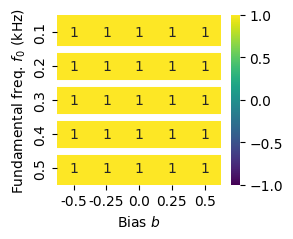

In [6]:
f0s = np.array(exp_configs["bias"]["freq"])
biases = np.array(exp_configs["bias"]["bias"])

results = pickle.load(open(f"./pkls/base_local_bias.pkl", "rb"))
feats = results["feats"].reshape(len(f0s), len(biases), -1)

dists = np.zeros((len(f0s), len(biases)))
for i in range(len(f0s)):
    for j in range(len(biases)):
        dists[i][j] = cosine_sim(feats[i, j][None, :], feats[i, 2][None, :]).item()

plt.figure(figsize=(3, 2.5))
ax = sns.heatmap(
    dists, annot=True, cmap="viridis", vmin=-1, vmax=1,
    xticklabels=biases, yticklabels=[f"{f0/1000:.1f}" for f0 in f0s])
ax.set(xlabel=r"Bias $b$", ylabel=r"Fundamental freq. $f_0$ (kHz)")

plt.axhline(1, color="white", linewidth=5)
plt.axhline(2, color="white", linewidth=5)
plt.axhline(3, color="white", linewidth=5)
plt.axhline(4, color="white", linewidth=5)

plt.tight_layout()
plt.savefig("plots/fig-f0-bias.pdf", bbox_inches="tight")

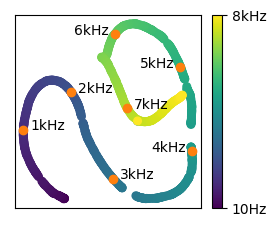

In [7]:
f0s = np.array(exp_configs["f0"]["freq"])
results = pickle.load(open(f"./pkls/base_local_f0.pkl", "rb"))
embedding = results["embs"]

plt.figure(figsize=(3, 2.5))
plt.scatter(
    embedding[:, 0], embedding[:, 1],
    c=plt.get_cmap('viridis')(np.linspace(0.0, 1.0, len(f0s))),
    alpha=1.0, s=30.0, marker='o',
)

for i, f0 in enumerate(f0s[:-1]):
    if i % 100 == 99:
        dx = [1, 1, 1, -6, -6, -6, 1, ]
        dy = [0, 0, 0, 0, 0, 0, 0, ]
        plt.text(
            embedding[i, 0] + dx[i//100], embedding[i, 1] + dy[i//100], f"{f0/1000:.0f}kHz",
            # bbox=dict(facecolor='white', alpha=0.2, linewidth=1)
        )
        plt.plot([embedding[i, 0]], [embedding[i, 1]], "o", c="C1")

cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels([f'{f0s[0]:.0f}Hz', f'{f0s[-1]/1000:.0f}kHz'])

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

# plt.tight_layout()
plt.savefig("plots/fig-f0-representation.pdf", bbox_inches="tight")


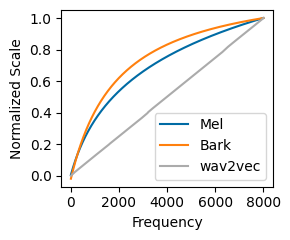

In [8]:
f0s = np.array(exp_configs["f0"]["freq"])
scales = {
    "Mel": 2595 * np.log(1 + f0s / 700),
    "Bark": (26.81 * f0s) / (1960 + f0s) - 0.53,
}

# Scale calculation
model_config = model_configs["base"]
results = pickle.load(open(f"./pkls/base_local_f0.pkl", "rb"))
feats = results["feats"]

# Cosine distance
dists = 2.0 - cosine_sim(feats, feats)[np.arange(0, len(feats) - 1), np.arange(1, len(feats))]
dists = np.insert(dists, 0, 0.0)

scale = np.add.accumulate(dists)
scales["wav2vec"] = scale

plt.figure(figsize=(3, 2.5))
for color, (name, scale) in zip(["C0", "C1", "C2", ], scales.items()):
    plt.plot(f0s, scale / scale[-1], label=name, c=color)

plt.legend(loc="lower right")
plt.xlabel("Frequency")
plt.ylabel("Normalized Scale")
plt.tight_layout()
plt.savefig("plots/fig-f0-scale.pdf", bbox_inches="tight")

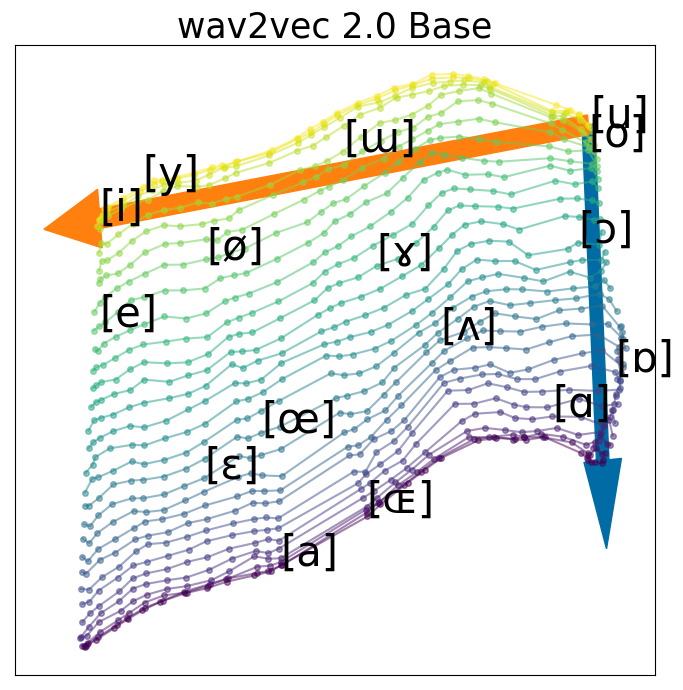

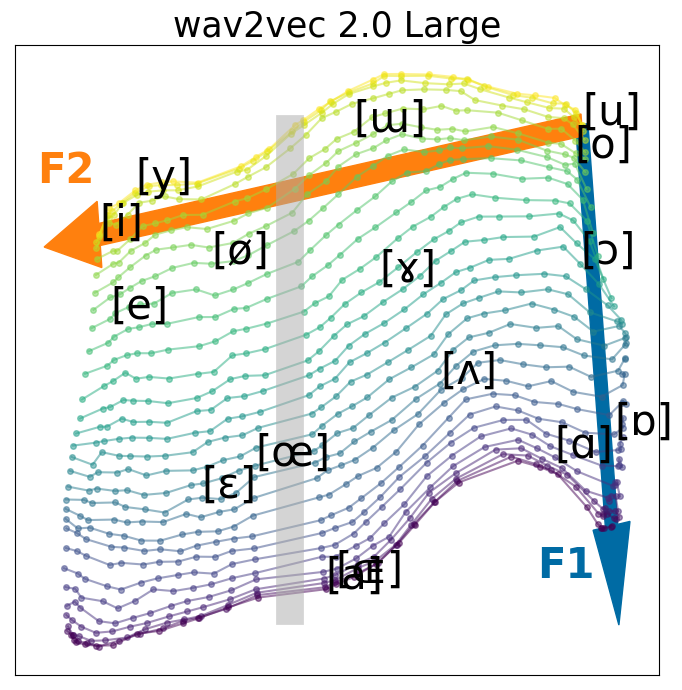

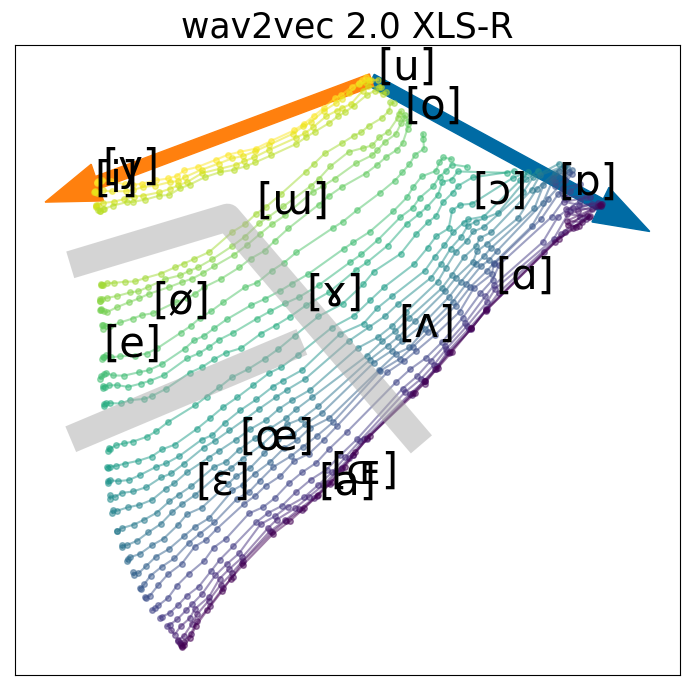

In [9]:
freqs = np.array(exp_configs["f1f2"]["freq"])
f1s = np.sort(np.unique(freqs[:, 1]))
f2s = np.sort(np.unique(freqs[:, 2]))

for model_key, model_config in model_configs.items():
    results = pickle.load(open(f"./pkls/{model_key}_local_f1f2.pkl", "rb"))
    embs = results["embs"].reshape(len(f1s), len(f2s), -1)

    plt.figure(figsize=(7, 7))
    plt.title(model_config["name"], fontsize=25)

    for i, freq in enumerate(f1s):
        plt.plot(
            embs[i, :, 0], embs[i, :, 1], 'o-',
            c=plt.get_cmap('viridis')(np.linspace(1.0, 0.0, len(f1s))[i]),
            alpha=0.5, markersize=4.0
        )

    plt.arrow(
        embs[0, 0, 0],
        embs[0, 0, 1],
        embs[len(f1s)-1, 0, 0] - embs[0, 0, 0],
        embs[len(f1s)-1, 0, 1] - embs[0, 0, 1],
        color='C0', width=0.3,
    )
    plt.arrow(
        embs[0, 0, 0],
        embs[0, 0, 1],
        embs[0, len(f2s)-1, 0] - embs[0, 0, 0],
        embs[0, len(f2s)-1, 1] - embs[0, 0, 1],
        color='C1', width=0.3,
    )

    vowels = zip(
        'ieɛaɑʌɤɯyøœɶɒɔou',
        [240, 390, 610, 850, 750, 600, 460, 300, 235, 370, 585, 820, 700, 500, 360, 250],
        [2400, 2300, 1900, 1610, 940, 1170, 1310, 1390, 2100, 1900, 1710, 1530, 750, 700, 640, 595],
        # ['[i]', '[ɪ]', '[e]', '[ɛ]', '[æ]', '[ɑ]', '[ɔ]', '[o]', '[ʊ]', '[u]', '[ʌ]'],
        # [280, 370, 405, 600, 860, 830, 560, 430, 400, 330, 680],
        # [2230, 2090, 2080, 1930, 1550, 1170, 820, 980, 1100, 1260, 1310],
    )

    for vowel, f1, f2 in vowels:
        i = np.searchsorted(f1s, f1)
        j = np.searchsorted(f2s, f2)
        if i == 30: i = 29
        if j == 30: j = 29
        plt.text(embs[i, j, 0], embs[i, j, 1], f"[{vowel}]", color='black', size=30)

    if model_key == "large":
        plt.text(embs[-1, 0, 0] - 1.8, embs[-1, 0, 1] + 0.7, "F1", size=30, c="C0", weight="bold")
        plt.text(embs[0, -1, 0] - 1.5, embs[0, -1, 1] - 0.7, "F2", size=30, c="C1", weight="bold")

    if model_key == "large":
        plt.plot([-0.5, -0.5], [10.5, 4], lw=20, alpha=0.5, c="C2")
    if model_key == "xls":
        plt.plot([-4, -0.5, 4], [9, 8, 13], lw=20, alpha=0.5, c="C2")
        plt.plot([-4, 1], [13, 11], lw=20, alpha=0.5, c="C2")

    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().invert_yaxis()    
    plt.tight_layout()
    plt.savefig(f"plots/fig-formant-f1f2-{model_key}.pdf", bbox_inches="tight")
    plt.show()


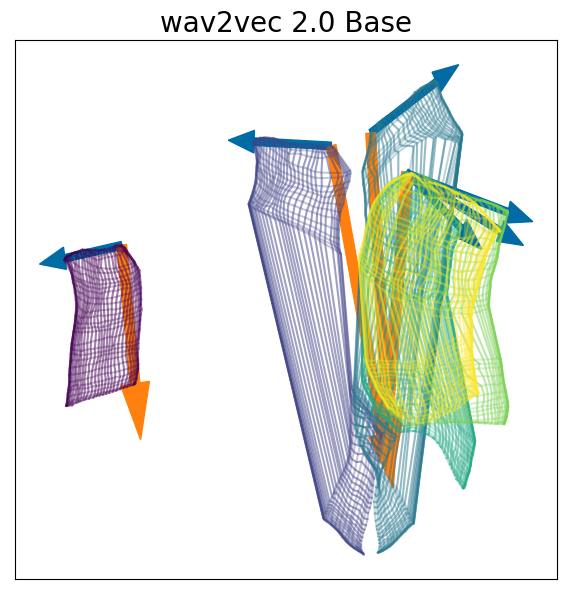

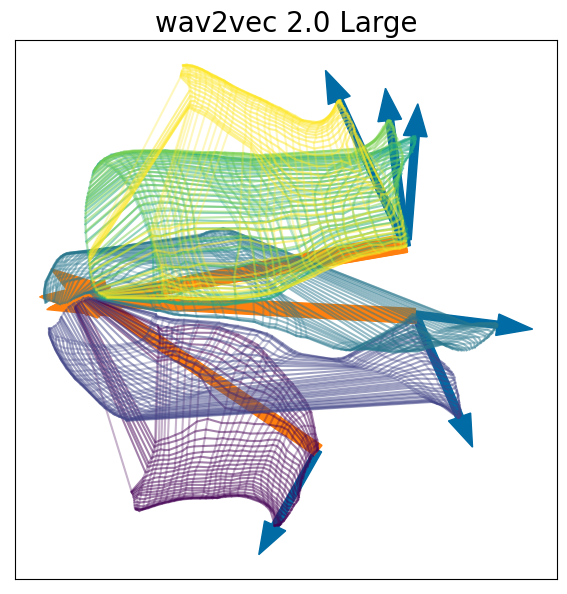

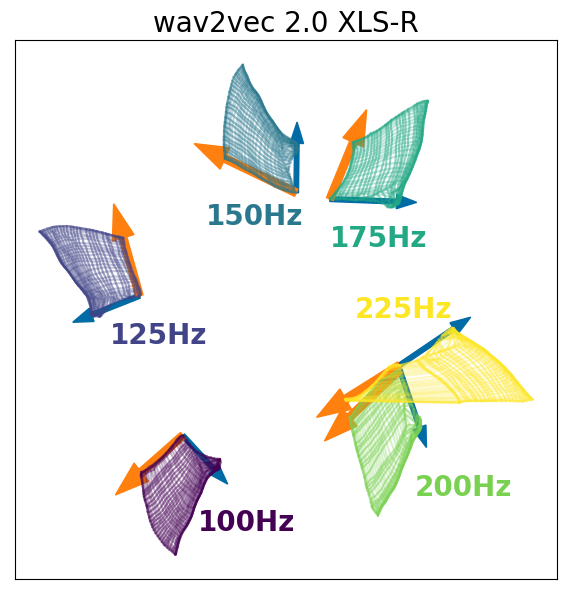

In [10]:
freqs = np.array(exp_configs["f0f1f2"]["freq"])
f0s = np.sort(np.unique(freqs[:, 0]))
f1s = np.sort(np.unique(freqs[:, 1]))
f2s = np.sort(np.unique(freqs[:, 2]))

for model_key, model_config in model_configs.items():
    results = pickle.load(open(f"./pkls/{model_key}_local_f0f1f2.pkl", "rb"))
    embs = results["embs"].reshape(len(f0s), len(f1s), len(f2s), -1)

    plt.figure(figsize=(7, 7))
    plt.title(model_config["name"], fontsize=20)

    for i, f0 in enumerate(f0s):
        c = plt.get_cmap('viridis')(np.linspace(0.0, 1.0, len(f0s))[i])

        for j, f1 in enumerate(f1s):
            plt.plot(
                embs[i, j, :, 0], embs[i, j, :, 1], '-',
                c=c, alpha=0.5
            )
        for k, f2 in enumerate(f2s):
            plt.plot(
                embs[i, :, k, 0], embs[i, :, k, 1], '-',
                c=c, alpha=0.3
            )

        plt.arrow(
            embs[i, 0, 0, 0],
            embs[i, 0, 0, 1],
            embs[i, len(f1s)-1, 0, 0] - embs[i, 0, 0, 0],
            embs[i, len(f1s)-1, 0, 1] - embs[i, 0, 0, 1],
            color='C0', width=0.3,
        )
        plt.arrow(
            embs[i, 0, 0, 0],
            embs[i, 0, 0, 1],
            embs[i, 0, len(f2s)-1, 0] - embs[i, 0, 0, 0],
            embs[i, 0, len(f2s)-1, 1] - embs[i, 0, 0, 1],
            color='C1', width=0.5,
        )

        # plt.text(embs[i, 0, 0, 0], embs[i, 0, 0, 1], f"{f0:.0f}")

        if model_key == "xls":
            dx = [ 1, -2, -6,  0,  1, -3, ]
            dy = [-6, -3, -2, -3, -8, 3, ]
            plt.text(embs[i, 0, 0, 0] + dx[i], embs[i, 0, 0, 1] + dy[i], f"{f0:.0f}Hz", size=20, c=c, weight="bold")
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    # plt.tight_layout()
    plt.savefig(f"plots/fig-f0f1f2-{model_key}.pdf", bbox_inches="tight")
    plt.show()

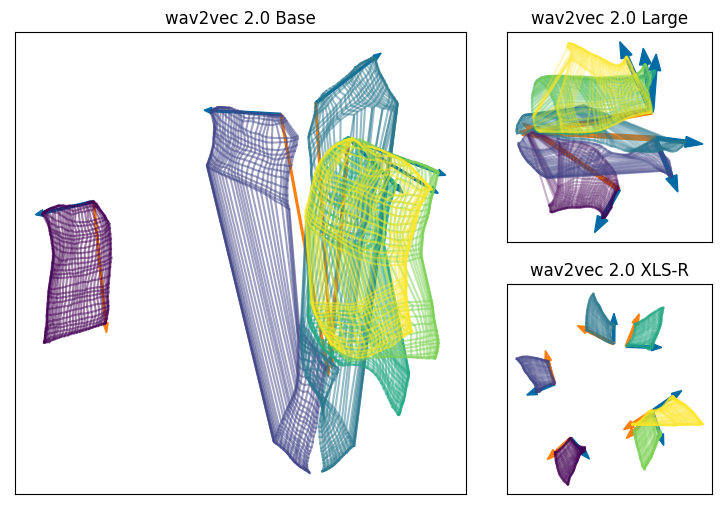

In [11]:
freqs = np.array(exp_configs["f0f1f2"]["freq"])
f0s = np.sort(np.unique(freqs[:, 0]))
f1s = np.sort(np.unique(freqs[:, 1]))
f2s = np.sort(np.unique(freqs[:, 2]))

fig = plt.figure(figsize=(9, 6))
gs = mpl.gridspec.GridSpec(2, 3)
axes = [
    fig.add_subplot(gs[0:2, 0:2]),
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 2]),
]

for (model_key, model_config), ax in zip(model_configs.items(), axes):
    results = pickle.load(open(f"./pkls/{model_key}_local_f0f1f2.pkl", "rb"))
    embs = results["embs"].reshape(len(f0s), len(f1s), len(f2s), -1)

    ax.set_title(model_config["name"])

    for i, f0 in enumerate(f0s):
        c = plt.get_cmap('viridis')(np.linspace(0.0, 1.0, len(f0s))[i])

        for j, f1 in enumerate(f1s):
            ax.plot(
                embs[i, j, :, 0], embs[i, j, :, 1], '-',
                c=c, alpha=0.5 if model_key == "base" else 0.3
            )
        for k, f2 in enumerate(f2s):
            ax.plot(
                embs[i, :, k, 0], embs[i, :, k, 1], '-',
                c=c, alpha=0.5 if model_key == "base" else 0.3
            )

        ax.arrow(
            embs[i, 0, 0, 0],
            embs[i, 0, 0, 1],
            embs[i, len(f1s)-1, 0, 0] - embs[i, 0, 0, 0],
            embs[i, len(f1s)-1, 0, 1] - embs[i, 0, 0, 1],
            color='C0', width=0.1 if model_key == "base" else 0.4,
        )
        ax.arrow(
            embs[i, 0, 0, 0],
            embs[i, 0, 0, 1],
            embs[i, 0, len(f2s)-1, 0] - embs[i, 0, 0, 0],
            embs[i, 0, len(f2s)-1, 1] - embs[i, 0, 0, 1],
            color='C1', width=0.1 if model_key == "base" else 0.4,
        )

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(f"plots/fig-f0f1f2-full.pdf", bbox_inches="tight")
plt.show()

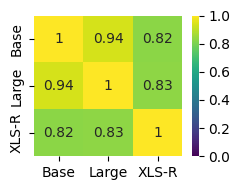

In [12]:
feats = {}

for model_key, model_config in model_configs.items():
    results = pickle.load(open(f"./pkls/{model_key}_local_f0f1f2.pkl", "rb"))
    feats[model_key] = {
        "feats": results["feats"],
        "name": model_config["shorthand"],
    }

dists = np.array([
    [1.0, 0.9350568046904754, 0.8245916932781951],
    [0.9350568046904754, 1.0, 0.8295691259093978],
    [0.8245916932781951, 0.8295691259093978, 1.0],
])

# Recalculate
if False:
    for i, (model_key, ri) in enumerate(feats.items()):
        for j, (model_key, rj) in enumerate(feats.items()):
            dists[i][j] = linear_cka_sim(ri["feats"], rj["feats"])
            print(dists[i][j])

names = [feat["name"] for feat in feats.values()]
plt.figure(figsize=(2.5, 2))
ax = sns.heatmap(
    dists, annot=True, cmap="viridis", vmin=0.0, vmax=1,
    xticklabels=names, yticklabels=names)
plt.tight_layout()
plt.savefig("plots/fig-formant-cka.pdf", bbox_inches="tight")

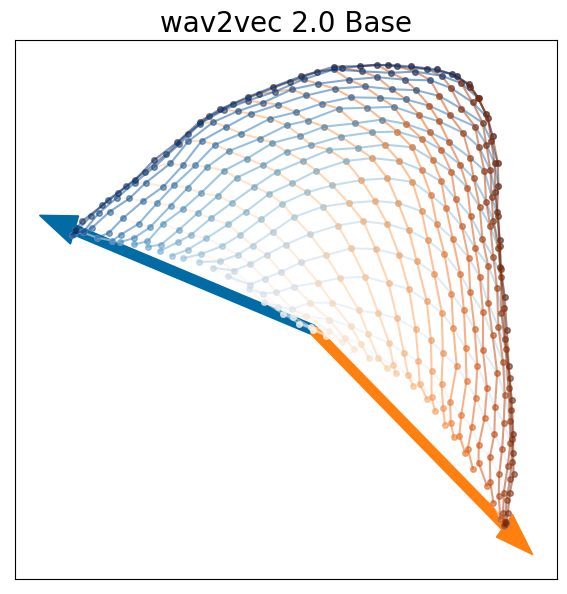

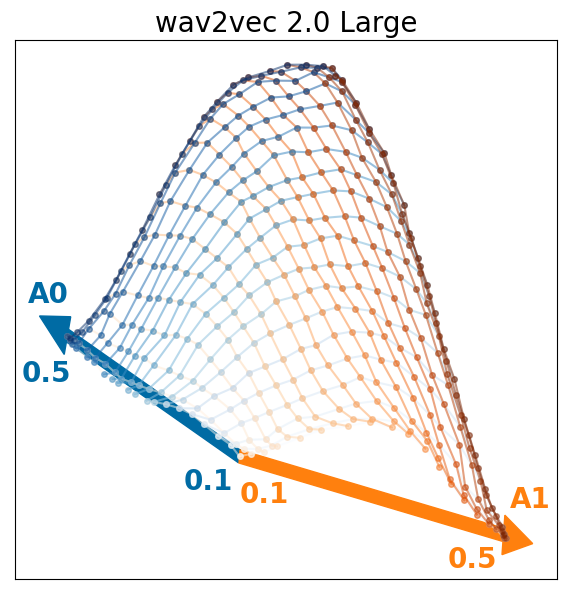

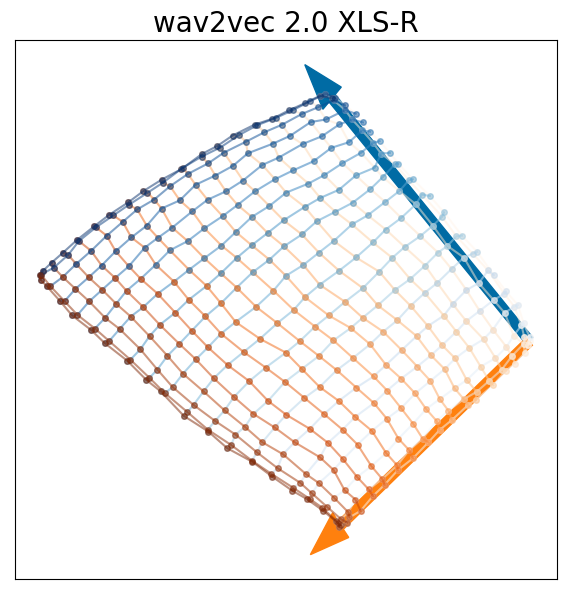

In [13]:
mags = np.array(exp_configs["w"]["mag"])
weights = np.sort(np.unique(mags[:, 0]))

for model_key, model_config in model_configs.items():
    results = pickle.load(open(f"./pkls/{model_key}_local_w.pkl", "rb"))
    embedding = results["embs"].reshape(len(weights), len(weights), -1)

    plt.figure(figsize=(7, 7))
    plt.title(model_config["name"], fontsize=20)

    for i, w in enumerate(weights):
        plt.plot(
            embedding[i, :, 0], embedding[i, :, 1], 'o-',
            c=plt.get_cmap('Blues')(np.linspace(0.0, 1.0, len(weights)))[i],
            alpha=0.5, markersize=4.0,
        )
        plt.plot(
            embedding[:, i, 0], embedding[:, i, 1], 'o-',
            c=plt.get_cmap('Oranges')(np.linspace(0.0, 1.0, len(weights)))[i],
            alpha=0.5, markersize=4.0,
        )

#     for i, w in enumerate(weights):
#         if i % (len(weights) // 5) == 0:
#             plt.text(embedding[i, -1, 0], embedding[i, -1, 1], f"A0={w:.1f}", bbox=dict(facecolor='white', alpha=0.5, linewidth=1))
#             plt.text(embedding[-1, i, 0], embedding[-1, i, 1] + 0.2, f"A1={w:.1f}", bbox=dict(facecolor='white', alpha=0.5, linewidth=1))
#             plt.text(embedding[i, 0, 0], embedding[i, 0, 1], f"A0={w:.1f}", bbox=dict(facecolor='white', alpha=0.5, linewidth=1))
#             plt.text(embedding[0, i, 0], embedding[0, i, 1] + 0.2, f"A1={w:.1f}", bbox=dict(facecolor='white', alpha=0.5, linewidth=1))


    plt.arrow(
        embedding[0, 0, 0],
        embedding[0, 0, 1],
        embedding[-1, 0, 0] - embedding[0, 0, 0],
        embedding[-1, 0, 1] - embedding[0, 0, 1],
        color='C0', width=0.2,
    )
    plt.arrow(
        embedding[0, 0, 0],
        embedding[0, 0, 1],
        embedding[0, -1, 0] - embedding[0, 0, 0],
        embedding[0, -1, 1] - embedding[0, 0, 1],
        color='C1', width=0.2,
    )

    if model_key == "large":
        plt.text(embedding[0, 0, 0] - 1.7, embedding[0, 0, 1] - 0.5, "0.1", size=20, c="C0", weight="bold")
        plt.text(embedding[0, 0, 0] , embedding[0, 0, 1] - 0.7, "0.1", size=20, c="C1", weight="bold")
        plt.text(embedding[-1, 0, 0] - 1.4, embedding[-1, 0, 1] - 0.7, "0.5", size=20, c="C0", weight="bold")
        plt.text(embedding[0, -1, 0] - 1.7, embedding[0, -1, 1] - 0.5, "0.5", size=20, c="C1", weight="bold")
        plt.text(embedding[-1, 0, 0] - 1.2, embedding[-1, 0, 1] + 0.5, "A0", size=20, c="C0", weight="bold")
        plt.text(embedding[0, -1, 0] + 0.2, embedding[0, -1, 1] + 0.4, "A1", size=20, c="C1", weight="bold")

    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.savefig(f"plots/fig-amplitude-{model_key}.pdf", bbox_inches="tight")
    plt.show()

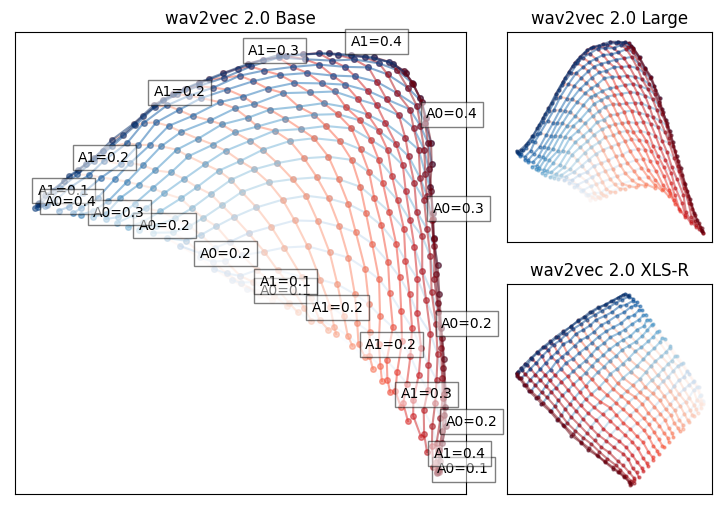

In [14]:
mags = np.array(exp_configs["w"]["mag"])
weights = np.sort(np.unique(mags[:, 0]))

fig = plt.figure(figsize=(9, 6))
gs = mpl.gridspec.GridSpec(2, 3)
axes = [
    fig.add_subplot(gs[0:2, 0:2]),
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 2]),
]

for (model_key, model_config), ax in zip(model_configs.items(), axes):
    results = pickle.load(open(f"./pkls/{model_key}_local_w.pkl", "rb"))
    embedding = results["embs"].reshape(len(weights), len(weights), -1)

    ax.set_title(model_config["name"])

    for i, w in enumerate(weights):
        ax.plot(
            embedding[i, :, 0], embedding[i, :, 1], 'o-',
            c=plt.get_cmap('Blues')(np.linspace(0.0, 1.0, len(weights)))[i],
            alpha=0.5, markersize=4.0 if model_key == "base" else 2.0,
        )
        ax.plot(
            embedding[:, i, 0], embedding[:, i, 1], 'o-',
            c=plt.get_cmap('Reds')(np.linspace(0.0, 1.0, len(weights)))[i],
            alpha=0.5, markersize=4.0 if model_key == "base" else 2.0,
        )

    if model_key == "base":
        for i, w in enumerate(weights):
            if i % (len(weights) // 5) == 0:
                ax.text(embedding[i, -1, 0], embedding[i, -1, 1], f"A0={w:.1f}", bbox=dict(facecolor='white', alpha=0.5, linewidth=1))
                ax.text(embedding[-1, i, 0], embedding[-1, i, 1] + 0.2, f"A1={w:.1f}", bbox=dict(facecolor='white', alpha=0.5, linewidth=1))
                ax.text(embedding[i, 0, 0], embedding[i, 0, 1], f"A0={w:.1f}", bbox=dict(facecolor='white', alpha=0.5, linewidth=1))
                ax.text(embedding[0, i, 0], embedding[0, i, 1] + 0.2, f"A1={w:.1f}", bbox=dict(facecolor='white', alpha=0.5, linewidth=1))

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(f"plots/fig-amplitude-full.pdf", bbox_inches="tight")
plt.show()